## Домашнее задание 5. GPT Induction Heads

На [семинаре 12](https://github.com/SergeyMalashenko/2024-ML3/blob/main/seminars/12_gpt/seminar12_gpt_filled.ipynb) мы уже писали GPT с нуля, поэтому для успешного выполнения задания рекомендуется обратиться к коду оттуда.


В этом задании вам предлагается воспроизвести эксперимент из статей [In-context Learning and Induction Heads](https://transformer-circuits.pub/2022/in-context-learning-and-induction-heads/index.html) и [Mamba](https://arxiv.org/abs/2312.00752).

На синтетической задаче индукции мы будем проверять обобщающие способности генерализации вариантов трансформера на более длинный контекст.

Сама задача похожа на примитивное языковое моделирование и решается так же, как next token prediction. Для текущего токена в последовательности таргетом является токен, следовавший за текущим токеном в прошлый раз; если он встречается впервые, мы будем игнорировать его при обучении. Так, для `abcab` таргетом будет `xxxbc`.

## 0. Загружаем данные
Тренировочную выборку будем случайно семплировать на каждой итерации, а тестовую зафиксируем для воспроизводимости.

In [ ]:
import random
import torch
from torch.utils.data import Dataset
from typing import List, Tuple
from tqdm.auto import tqdm

class InductionDataset(Dataset):
    def __init__(self, max_length: int = 256, vocab_size: int = 16, dataset_size: int = 1000, offline=False):
        self.vocab_size = vocab_size
        self.vocab = "".join([chr(ord("a") + x) for x in range(vocab_size)])
        self.max_length = max_length
        self.dataset_size = dataset_size
        self.data: List[Tuple[torch.Tensor, torch.Tensor]] = []
        if offline:
            self._regenerate_data()
        self.offline = offline

    def _generate_random_string(self) -> str:
        return ''.join(random.choice(self.vocab) for _ in range(self.max_length))

    def _generate_ground_truth(self, sequence: torch.Tensor) -> torch.Tensor:
        last_seen = {}
        result = []

        for i, char in enumerate(sequence):
            char = int(char)
            prev_index = last_seen.get(char, -1)
            if prev_index > -1:
                result.append(sequence[prev_index + 1])
            else:
                result.append(-100)
            last_seen[char] = i

        return torch.tensor(result, dtype=torch.long)

    def _generate_sample(self):
        sequence = self._generate_random_string()
        sequence_tensor = torch.tensor([self.vocab.index(char) for char in sequence], dtype=torch.long)
        label_tensor = self._generate_ground_truth(sequence_tensor)
        return (sequence_tensor, label_tensor)

    def _regenerate_data(self):
        self.data = []
        for _ in tqdm(range(self.dataset_size)):
            self.data.append(self._generate_sample())

    def __getitem__(self, index: int) -> Tuple[torch.Tensor, torch.Tensor]:
        if self.offline:
            return self.data[index]
        else:
            return self._generate_sample()

    def __len__(self) -> int:
        return self.dataset_size


train_max_sequence_length = 256
train_dataset_size = 8192
train_dataset = InductionDataset(train_max_sequence_length, dataset_size=train_dataset_size)
# Create a DataLoader for the dataset
from torch.utils.data import DataLoader

train_loader = DataLoader(train_dataset, batch_size=8, shuffle=False, drop_last=True, num_workers=4, persistent_workers=True, pin_memory=True)
max_test_sequence_length = 256 * 32
test_dataset_size = 512
test_dataset = InductionDataset(max_test_sequence_length, dataset_size=test_dataset_size, offline=True)
test_loader = DataLoader(test_dataset, batch_size=2, shuffle=False, drop_last=False, num_workers=0)


/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:617: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(


  0%|          | 0/512 [00:00<?, ?it/s]

Шаги воспроизведения эксперимента:

1. Реализовать decoder transformer с абсолютным позиционным кодированием (из оригинального Attention is All You Need) и *без* позиционного кодирования вовсе. (5 баллов)
2. Обучить как бейзлайны версии трансформеров из 1, отрепортить loss и accuracy во время обучения. (3 балла)
3. Реализовать подсчёт метрики на валидации с усреднением по корзинам длины: на длине претрейна, на длине в 2 раза больше и т. д. и замерить модели из 2. (2  балла)
4. Дополнить трансформер 2 видами продвинутого позиционного кодирования: [ALiBi](https://arxiv.org/abs/2108.12409) и одним из [RoPE](https://arxiv.org/abs/2104.09864)/[xPos](https://arxiv.org/abs/2212.10554). (6 баллов)
5. Обучить модели из 4, сделать вывод о качестве генерализации по сравнению с бейзлайнами. (4 балла)
6. (bonus) Обучить и протестировать модель с блоком Mamba вместо блока трансформера, сделать выводы. (10 баллов)

## 1. Ванильный GPT
Здесь и далее используем attention only трансформер **без** MLP блока, так как 2 последовательных attention способны решать нашу задачу в явном виде.

In [ ]:
import torch
import torch.nn as nn
import math
from tqdm.auto import tqdm
import torch.nn.functional as F

class PositionalEncoding(nn.Module):
    def __init__(self, d_model, seq_len):
        super().__init__()
        self.d_model = d_model
        self.seq_len = seq_len
        # Create a matrix of shape (seq_len, d_model)
        pe = torch.zeros(seq_len, d_model)
        # Create a vector of shape (seq_len)
        position = torch.arange(0, seq_len, dtype=torch.float).unsqueeze(1)  # (seq_len, 1)
        # Create a vector of shape (d_model)
        div_term = torch.exp(torch.arange(0, d_model, 2).float() * (-math.log(10000.0) / d_model))  # (d_model / 2)
        # Apply sine to even indices
        pe[:, 0::2] = torch.sin(position * div_term)  # sin(position * (10000 ** (2i / d_model)))
        # Apply cosine to odd indices
        pe[:, 1::2] = torch.cos(position * div_term)  # cos(position * (10000 ** (2i / d_model)))
        # Add a batch dimension to the positional encoding
        pe = pe.unsqueeze(0)  # (1, seq_len, d_model)
        # Register the positional encoding as a buffer
        self.register_buffer('pe', pe)

    def forward(self, x):
        # Ensure the positional encoding is added to the input tensor
        return x + self.pe[:, :x.shape[1], :].to(x.device)  # (batch, seq_len, d_model)

class MultiHeadAttention(nn.Module):
    def __init__(self, d_model, n_heads, qkv_bias = True):
        super().__init__()
        assert d_model % n_heads == 0, "d_model is not divisible by h"
        self.d_model = d_model
        self.n_heads = n_heads
        self.d_head = d_model // n_heads
        self.query = nn.Linear(d_model, d_model, bias = qkv_bias)
        self.key = nn.Linear(d_model, d_model, bias = qkv_bias)
        self.value = nn.Linear(d_model, d_model, bias = qkv_bias)
        self.out = nn.Linear(d_model, d_model)
        self.scale = self.d_head ** -0.5

    def forward(self, x):
        B, L, D = x.shape
        query = self.query(x).view(B, L, self.n_heads, self.d_head).permute(0, 2, 1, 3)
        key = self.key(x).view(B, L, self.n_heads, self.d_head).permute(0, 2, 1, 3)
        value = self.value(x).view(B, L, self.n_heads, self.d_head).permute(0, 2, 1, 3)

        dots = (query @ key.transpose(-1, -2)) * self.scale

        mask = torch.tril(torch.ones((L, L))).to(x.device)
        dots.masked_fill_(mask == 0, float('-inf'))

        att_scores = dots.softmax(-1)
        att_v = att_scores @ value

        out = att_v.permute(0, 2, 1, 3).contiguous().view(B, L, D)

        out = self.out(out)

        return out

import torch.nn as nn

class TransformerDecoderBlock(nn.Module):
    def __init__(self, d_model, n_heads, qkv_bias = True):
        super().__init__()
        self.layer_norm_1 = nn.LayerNorm(d_model)
        self.layer_norm_2 = nn.LayerNorm(d_model)

        self.MHA = MultiHeadAttention(d_model, n_heads, qkv_bias)
        self.MLP = nn.Sequential(nn.Linear(d_model, 4 * d_model), nn.ReLU(), nn.Linear(4 * d_model, d_model))

    def forward(self, x):

        x = self.layer_norm_1(self.MHA(x)) + x
        x = self.layer_norm_2(self.MLP(x)) + x

        return x


class TransformerDecoder(nn.Module):
    def __init__(self, vocab_size, d_model, n_heads, n_blocks,qkv_bias = True, seq_len = train_dataset_size, use_positional_encoding=True):
        super().__init__()
        self.embedding = nn.Embedding(vocab_size, d_model)
        self.pos_encoding = PositionalEncoding(d_model, seq_len) if use_positional_encoding else None
        self.blocks = nn.ModuleList([TransformerDecoderBlock(d_model, n_heads, qkv_bias) for _ in range(n_blocks)])
        self.fc_out = nn.Linear(d_model, vocab_size)

    def forward(self, x):
        x = self.embedding(x)  # (batch_size, seq_len, d_model)
        if self.pos_encoding:
            x = self.pos_encoding(x)
        for block in self.blocks:
            x = block(x)
        x = self.fc_out(x)  # (batch_size, seq_len, vocab_size)
        return x

## 2. Учим GPT
Не забудьте использовать подходящее [расписание](https://huggingface.co/docs/transformers/en/main_classes/optimizer_schedules#schedules) learning rate и подрезку градиентов во время обучения. Бейзлайны должны сходиться за 20-25 эпох на наших данных.

In [ ]:
import wandb
from tqdm.auto import tqdm

def train_transformer(model, optimizer, scheduler, loss_fn, train_loader, device, num_epochs=10):
    wandb.init(project="HW5", config={
        "learning_rate": optimizer.param_groups[0]["lr"],
        "batch_size": train_loader.batch_size,
        "num_epochs": num_epochs,
    })

    model.train()

    for epoch in range(num_epochs):
        epoch_loss = 0.0
        epoch_accuracy = 0.0
        total_tokens = 0

        progress_bar = tqdm(train_loader, desc=f"Epoch {epoch+1}/{num_epochs}", leave=False)

        for batch_idx, (sequences, labels) in enumerate(progress_bar):
            sequences = sequences.to(device)
            labels = labels.to(device)

            optimizer.zero_grad()
            outputs = model(sequences)

            logits = outputs.view(-1, outputs.size(-1))  # (batch_size * seq_len, vocab_size)
            targets = labels.view(-1)  # (batch_size * seq_len)

            loss = loss_fn(logits, targets)

            non_padding_mask = targets != -100
            correct_predictions = (logits.argmax(dim=-1) == targets) & non_padding_mask
            accuracy = correct_predictions.sum().item()
            total_tokens += non_padding_mask.sum().item()
            epoch_accuracy += accuracy

            loss.backward()
            optimizer.step()

            if scheduler:
                scheduler.step()

            epoch_loss += loss.item()

            progress_bar.set_postfix(loss=loss.item(), accuracy=accuracy / non_padding_mask.sum())

        avg_loss = epoch_loss / len(train_loader)
        avg_accuracy = epoch_accuracy / total_tokens

        wandb.log({"epoch_loss": avg_loss, "epoch_accuracy": avg_accuracy})

        print(f"Epoch [{epoch + 1}/{num_epochs}] completed. Average Loss: {avg_loss:.4f}, Average Accuracy: {avg_accuracy:.4f}")

    wandb.finish()


In [ ]:
from transformers.optimization import Adafactor, AdafactorSchedule

DEVICE = "cuda"
#  конфигурацию модели не менять!
D_MODEL = 128
N_HEADS = 8
N_BLOCKS = 2
model_pos = TransformerDecoder(train_dataset.vocab_size, D_MODEL, N_HEADS, N_BLOCKS).to(DEVICE)
model_no_pos = TransformerDecoder(train_dataset.vocab_size, D_MODEL, N_HEADS, N_BLOCKS, use_positional_encoding=False).to(DEVICE)


loss_fn_pos = nn.CrossEntropyLoss()
optimizer_pos = torch.optim.AdamW(model_pos.parameters(), lr=1e-3, weight_decay=1e-5)

loss_fn_no_pos = nn.CrossEntropyLoss()
optimizer_no_pos = torch.optim.AdamW(model_no_pos.parameters(), lr=1e-3, weight_decay=1e-5)
# Настройка планировщика (опционально)
scheduler = None #AdafactorSchedule(optimizer)  # Например, можно использовать lr_scheduler из PyTorch


In [ ]:

# Запуск обучения
train_transformer(
    model=model_pos,
    optimizer=optimizer_pos,
    scheduler=scheduler,
    loss_fn=loss_fn_pos,
    train_loader=train_loader,
    device=DEVICE,
    num_epochs=20
)




wandb: Using wandb-core as the SDK backend.  Please refer to https://wandb.me/wandb-core for more information.


<IPython.core.display.Javascript object>

wandb: Logging into wandb.ai. (Learn how to deploy a W&B server locally: https://wandb.me/wandb-server)
wandb: You can find your API key in your browser here: https://wandb.ai/authorize
wandb: Paste an API key from your profile and hit enter, or press ctrl+c to quit:

 ··········


wandb: Appending key for api.wandb.ai to your netrc file: /root/.netrc


Epoch 1/20:   0%|          | 0/1024 [00:00<?, ?it/s]

Epoch [1/20] completed. Average Loss: 1.0844, Average Accuracy: 0.6513


Epoch 2/20:   0%|          | 0/1024 [00:00<?, ?it/s]

Epoch [2/20] completed. Average Loss: 0.0352, Average Accuracy: 0.9896


Epoch 3/20:   0%|          | 0/1024 [00:00<?, ?it/s]

Epoch [3/20] completed. Average Loss: 0.0200, Average Accuracy: 0.9942


Epoch 4/20:   0%|          | 0/1024 [00:00<?, ?it/s]

Epoch [4/20] completed. Average Loss: 0.0159, Average Accuracy: 0.9955


Epoch 5/20:   0%|          | 0/1024 [00:00<?, ?it/s]

Epoch [5/20] completed. Average Loss: 0.0124, Average Accuracy: 0.9965


Epoch 6/20:   0%|          | 0/1024 [00:00<?, ?it/s]

Epoch [6/20] completed. Average Loss: 0.0098, Average Accuracy: 0.9972


Epoch 7/20:   0%|          | 0/1024 [00:00<?, ?it/s]

Epoch [7/20] completed. Average Loss: 0.0083, Average Accuracy: 0.9977


Epoch 8/20:   0%|          | 0/1024 [00:00<?, ?it/s]

Epoch [8/20] completed. Average Loss: 0.0072, Average Accuracy: 0.9980


Epoch 9/20:   0%|          | 0/1024 [00:00<?, ?it/s]

Epoch [9/20] completed. Average Loss: 0.0062, Average Accuracy: 0.9983


Epoch 10/20:   0%|          | 0/1024 [00:00<?, ?it/s]

Epoch [10/20] completed. Average Loss: 0.0049, Average Accuracy: 0.9987


Epoch 11/20:   0%|          | 0/1024 [00:00<?, ?it/s]

Epoch [11/20] completed. Average Loss: 0.0053, Average Accuracy: 0.9986


Epoch 12/20:   0%|          | 0/1024 [00:00<?, ?it/s]

Epoch [12/20] completed. Average Loss: 0.0045, Average Accuracy: 0.9988


Epoch 13/20:   0%|          | 0/1024 [00:00<?, ?it/s]

Epoch [13/20] completed. Average Loss: 0.0044, Average Accuracy: 0.9988


Epoch 14/20:   0%|          | 0/1024 [00:00<?, ?it/s]

Epoch [14/20] completed. Average Loss: 0.0033, Average Accuracy: 0.9991


Epoch 15/20:   0%|          | 0/1024 [00:00<?, ?it/s]

Epoch [15/20] completed. Average Loss: 0.0037, Average Accuracy: 0.9990


Epoch 16/20:   0%|          | 0/1024 [00:00<?, ?it/s]

Epoch [16/20] completed. Average Loss: 0.0030, Average Accuracy: 0.9992


Epoch 17/20:   0%|          | 0/1024 [00:00<?, ?it/s]

Epoch [17/20] completed. Average Loss: 0.0030, Average Accuracy: 0.9992


Epoch 18/20:   0%|          | 0/1024 [00:00<?, ?it/s]

Epoch [18/20] completed. Average Loss: 0.0031, Average Accuracy: 0.9992


Epoch 19/20:   0%|          | 0/1024 [00:00<?, ?it/s]

Epoch [19/20] completed. Average Loss: 0.0027, Average Accuracy: 0.9993


Epoch 20/20:   0%|          | 0/1024 [00:00<?, ?it/s]

Epoch [20/20] completed. Average Loss: 0.0031, Average Accuracy: 0.9992


epoch_accuracy,▁███████████████████
epoch_loss,█▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
epoch_accuracy,0.99924
epoch_loss,0.00307


/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:617: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(
wandb: Currently logged in as: dragon22831 (arsen21). Use `wandb login --relogin` to force relogin


Epoch 1/20:   0%|          | 0/1024 [00:00<?, ?it/s]

Epoch [1/20] completed. Average Loss: 2.4481, Average Accuracy: 0.1970


Epoch 2/20:   0%|          | 0/1024 [00:00<?, ?it/s]

Epoch [2/20] completed. Average Loss: 1.9455, Average Accuracy: 0.3593


Epoch 3/20:   0%|          | 0/1024 [00:00<?, ?it/s]

Epoch [3/20] completed. Average Loss: 1.7274, Average Accuracy: 0.4322


Epoch 4/20:   0%|          | 0/1024 [00:00<?, ?it/s]

Epoch [4/20] completed. Average Loss: 1.5797, Average Accuracy: 0.4815


Epoch 5/20:   0%|          | 0/1024 [00:00<?, ?it/s]

Epoch [5/20] completed. Average Loss: 1.4780, Average Accuracy: 0.5155


Epoch 6/20:   0%|          | 0/1024 [00:00<?, ?it/s]

Epoch [6/20] completed. Average Loss: 1.4072, Average Accuracy: 0.5394


Epoch 7/20:   0%|          | 0/1024 [00:00<?, ?it/s]

Epoch [7/20] completed. Average Loss: 1.3533, Average Accuracy: 0.5577


Epoch 8/20:   0%|          | 0/1024 [00:00<?, ?it/s]

Epoch [8/20] completed. Average Loss: 1.3165, Average Accuracy: 0.5708


Epoch 9/20:   0%|          | 0/1024 [00:00<?, ?it/s]

Epoch [9/20] completed. Average Loss: 1.2806, Average Accuracy: 0.5836


Epoch 10/20:   0%|          | 0/1024 [00:00<?, ?it/s]

Epoch [10/20] completed. Average Loss: 1.2583, Average Accuracy: 0.5911


Epoch 11/20:   0%|          | 0/1024 [00:00<?, ?it/s]

Epoch [11/20] completed. Average Loss: 1.2344, Average Accuracy: 0.5996


Epoch 12/20:   0%|          | 0/1024 [00:00<?, ?it/s]

Epoch [12/20] completed. Average Loss: 1.2163, Average Accuracy: 0.6064


Epoch 13/20:   0%|          | 0/1024 [00:00<?, ?it/s]

Epoch [13/20] completed. Average Loss: 1.2025, Average Accuracy: 0.6109


Epoch 14/20:   0%|          | 0/1024 [00:00<?, ?it/s]

Epoch [14/20] completed. Average Loss: 1.1887, Average Accuracy: 0.6160


Epoch 15/20:   0%|          | 0/1024 [00:00<?, ?it/s]

Epoch [15/20] completed. Average Loss: 1.1763, Average Accuracy: 0.6207


Epoch 16/20:   0%|          | 0/1024 [00:00<?, ?it/s]

Epoch [16/20] completed. Average Loss: 1.1647, Average Accuracy: 0.6242


Epoch 17/20:   0%|          | 0/1024 [00:00<?, ?it/s]

Epoch [17/20] completed. Average Loss: 1.1551, Average Accuracy: 0.6281


Epoch 18/20:   0%|          | 0/1024 [00:00<?, ?it/s]

Epoch [18/20] completed. Average Loss: 1.1437, Average Accuracy: 0.6321


Epoch 19/20:   0%|          | 0/1024 [00:00<?, ?it/s]

Epoch [19/20] completed. Average Loss: 1.1350, Average Accuracy: 0.6356


Epoch 20/20:   0%|          | 0/1024 [00:00<?, ?it/s]

Epoch [20/20] completed. Average Loss: 1.1261, Average Accuracy: 0.6379


epoch_accuracy,▁▄▅▆▆▆▇▇▇▇▇█████████
epoch_loss,█▅▄▃▃▂▂▂▂▂▂▁▁▁▁▁▁▁▁▁
epoch_accuracy,0.63788
epoch_loss,1.12612


In [ ]:
train_loader = DataLoader(train_dataset, batch_size=8, shuffle=False, drop_last=True, num_workers=4, persistent_workers=True, pin_memory=True)

train_transformer(
    model=model_no_pos,
    optimizer=optimizer_no_pos,
    scheduler=scheduler,
    loss_fn=loss_fn_no_pos,
    train_loader=train_loader,
    device=DEVICE,
    num_epochs=20
)

## 3. Замеряем качество
Вам необходимо посчитать и визуализировать accuracy внутри каждого из интервалов длин: `[0, 256], [256, 512], ..., [4096, 8192]`.

Также полезно реализовать heatmap по интервалам меньшей гранулярности, чтобы отследить деградацию качества (опционально).

In [ ]:
import torch
ot = []
lb = []
def eval_accuracy_bins(model, test_loader, bins=[0] + [2**x for x in range(8, 14)]):
    global ot
    global lb
    model.eval()
    accuracy_by_bins = {f"{bins[i]}-{bins[i+1]}": [] for i in range(len(bins)-1)}

    with torch.no_grad():
        for batch in tqdm(test_loader):
            sequences, labels = batch
            sequences, labels = sequences.to(DEVICE), labels.to(DEVICE)
            outputs = model(sequences)

            preds = outputs.argmax(dim=-1)


            for bin_start, bin_end in zip(bins[:-1], bins[1:]):
                tmp_preds = preds[:,bin_start:bin_end+1]
                tmp_target = labels[:,bin_start:bin_end+1]

                y_pred = tmp_preds.view(-1, tmp_preds.size(-1))
                y_true = tmp_target.view(-1, tmp_target.size(-1))
                non_padding_mask = y_true != -100
                correct_predictions = (y_pred == y_true) & non_padding_mask
                accuracy = correct_predictions.sum().item()
                total_tokens = non_padding_mask.sum().item()

                accuracy_by_bins[f"{bin_start}-{bin_end}"].append(accuracy/total_tokens)


    # Средняя точность по каждому интервалу
    mean_accuracy_by_bins = {k: sum(v) / len(v) if v else 0 for k, v in accuracy_by_bins.items()}

    return mean_accuracy_by_bins


In [ ]:
import seaborn as sns
import matplotlib.pyplot as plt

def plot_accuracy_heatmap_(accuracy_by_bins):

    bin_labels = accuracy_by_bins.keys()
    accuracy_matrix = [accuracy_by_bins[bin_] for bin_ in bin_labels]

    plt.figure(figsize=(10, 6))
    sns.heatmap([accuracy_matrix], cmap='Blues', annot=True, xticklabels=bin_labels, yticklabels=['Accuracy'],
                cbar_kws={'label': 'Accuracy'}, vmin=0, vmax=1)
    plt.xlabel('Sequence Length Bin')
    plt.title('Accuracy by Sequence Length Bins')
    plt.show()


  0%|          | 0/256 [00:00<?, ?it/s]

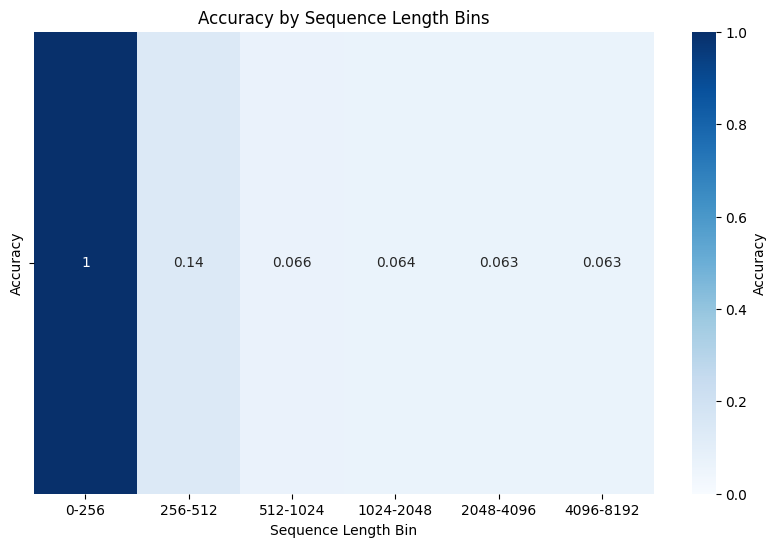

In [ ]:
accuracy_by_bins = eval_accuracy_bins(model_pos, test_loader)
plot_accuracy_heatmap_(accuracy_by_bins)



  0%|          | 0/256 [00:00<?, ?it/s]

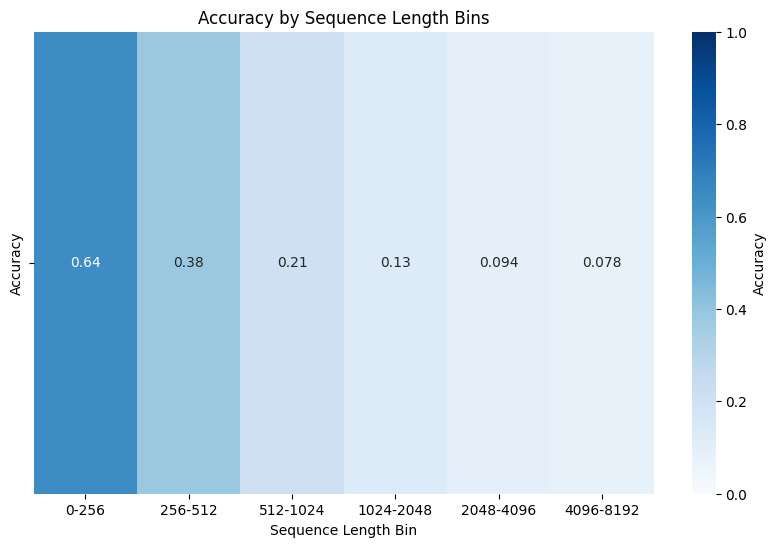

In [ ]:
accuracy_by_bins = eval_accuracy_bins(model_no_pos, test_loader)
plot_accuracy_heatmap_(accuracy_by_bins)

видим что без позиционки у нас менее резкая деградация, но зато более худшая точность на коротких семплах, хз как нам это поможет))

## 4. GPT с улучшенным позиционным кодированием
Приведённые виды кодирования необходимо интегрировать в сам блок attention.

#ALIBI

In [ ]:
import torch
import torch.nn as nn

def generate_alibi_bias(seq_len, n_heads, device="cpu"):
    """
    Generate ALiBi bias for attention.

    Args:
        seq_len (int): Length of the sequence.
        n_heads (int): Number of attention heads.
        device (str): Device for the generated bias tensor.

    Returns:
        torch.Tensor: ALiBi bias tensor with shape (1, n_heads, seq_len, seq_len).
    """
    slopes = torch.pow(2.0, torch.arange(0, n_heads, dtype=torch.float32, device=device) / n_heads)
    alibi = torch.arange(seq_len, device=device).unsqueeze(0) - torch.arange(seq_len, device=device).unsqueeze(1)
    alibi = alibi.unsqueeze(0).unsqueeze(0) * slopes.view(n_heads, 1, 1)
    return alibi

class MultiHeadAttentionALiBi(nn.Module):
    def __init__(self, d_model, n_heads, qkv_bias=True):
        super().__init__()
        assert d_model % n_heads == 0, "d_model must be divisible by n_heads."
        self.d_model = d_model
        self.n_heads = n_heads
        self.d_head = d_model // n_heads
        self.query = nn.Linear(d_model, d_model, bias=qkv_bias)
        self.key = nn.Linear(d_model, d_model, bias=qkv_bias)
        self.value = nn.Linear(d_model, d_model, bias=qkv_bias)
        self.out = nn.Linear(d_model, d_model)
        self.scale = self.d_head ** -0.5

    def forward(self, x):
        B, L, D = x.shape
        device = x.device

        query = self.query(x).view(B, L, self.n_heads, self.d_head).transpose(1, 2)  # (B, n_heads, L, d_head)
        key = self.key(x).view(B, L, self.n_heads, self.d_head).transpose(1, 2)      # (B, n_heads, L, d_head)
        value = self.value(x).view(B, L, self.n_heads, self.d_head).transpose(1, 2)  # (B, n_heads, L, d_head)

        #dot-product
        dots = (query @ key.transpose(-1, -2)) * self.scale  # (B, n_heads, L, L)
        alibi_bias = generate_alibi_bias(L, self.n_heads, device=device)  # (1, n_heads, L, L)
        dots += alibi_bias

        mask = torch.tril(torch.ones((L, L), device=device)).unsqueeze(0).unsqueeze(0)  # (1, 1, L, L)
        dots.masked_fill_(mask == 0, float('-inf'))
        att_scores = dots.softmax(dim=-1)

        att_v = att_scores @ value  # (B, n_heads, L, d_head)

        out = att_v.transpose(1, 2).contiguous().view(B, L, D)  # (B, L, D)
        out = self.out(out)
        return out



class TransformerDecoderBlock(nn.Module):
    def __init__(self, d_model, n_heads, qkv_bias = True):
        super().__init__()
        self.layer_norm_1 = nn.LayerNorm(d_model)
        self.layer_norm_2 = nn.LayerNorm(d_model)

        self.MHA = MultiHeadAttention(d_model, n_heads, qkv_bias)
        self.MLP = nn.Sequential(nn.Linear(d_model, 4 * d_model), nn.ReLU(), nn.Linear(4 * d_model, d_model))

    def forward(self, x):

        x = self.layer_norm_1(self.MHA(x)) + x
        x = self.layer_norm_2(self.MLP(x)) + x

        return x


class TransformerDecoderBlockALIBI(nn.Module):
    def __init__(self, d_model, n_heads, qkv_bias = True, dropout=0.1):
        super().__init__()
        self.layer_norm_1 = nn.LayerNorm(d_model)
        self.layer_norm_2 = nn.LayerNorm(d_model)

        self.dropout = nn.Dropout(dropout)

        self.MHA = MultiHeadAttentionALiBi(d_model, n_heads, qkv_bias)
        self.MLP = nn.Sequential(nn.Linear(d_model, 4*d_model),nn.ReLU(),nn.Linear(4*d_model, d_model),)

    def forward(self, x):
        attn_output = self.MHA(x)
        x = self.layer_norm_1(x + self.dropout(attn_output))

        # FFN
        ffn_output = self.MLP(x)
        x = self.layer_norm_2(x + self.dropout(ffn_output))
        return x



class TransformerDecoderALIBI(nn.Module):
    def __init__(self, vocab_size, d_model, n_heads, n_blocks,qkv_bias = True,dropout = 0.1, seq_len = train_dataset_size, use_positional_encoding=True):
        super().__init__()
        self.embedding = nn.Embedding(vocab_size, d_model)
        self.pos_encoding = PositionalEncoding(d_model, seq_len) if use_positional_encoding else None
        self.blocks = nn.ModuleList([TransformerDecoderBlockALIBI(d_model, n_heads, qkv_bias, dropout) for _ in range(n_blocks)])
        self.fc_out = nn.Linear(d_model, vocab_size)

    def forward(self, x):
        x = self.embedding(x)  # (batch_size, seq_len, d_model)
        if self.pos_encoding:
            x = self.pos_encoding(x)
        for block in self.blocks:
            x = block(x)
        x = self.fc_out(x)  # (batch_size, seq_len, vocab_size)
        return x


#ROPE

In [ ]:
from typing import Optional, Tuple
def precompute_freqs_cis(dim: int, end: int, theta: float = 10000.0):
    freqs = 1.0 / (theta ** (torch.arange(0, dim, 2)[: (dim // 2)].float() / dim))
    t = torch.arange(end, device=freqs.device)  # type: ignore
    freqs = torch.outer(t, freqs).float()  # type: ignore
    freqs_cis = torch.polar(torch.ones_like(freqs), freqs)  # complex64
    return freqs_cis


def reshape_for_broadcast(freqs_cis: torch.Tensor, x: torch.Tensor):
    ndim = x.ndim
    assert 0 <= 1 < ndim
    assert freqs_cis.shape == (x.shape[1], x.shape[-1]), f'{freqs_cis.shape} - {(x.shape[1], x.shape[-1])}'
    shape = [d if i == 1 or i == ndim - 1 else 1 for i, d in enumerate(x.shape)]
    return freqs_cis.view(*shape)


def apply_rotary_emb(
    xq: torch.Tensor,
    xk: torch.Tensor,
    freqs_cis: torch.Tensor,
) -> Tuple[torch.Tensor, torch.Tensor]:

    xq_ = torch.view_as_complex(xq.float().reshape(*xq.shape[:-1], -1, 2))
    xk_ = torch.view_as_complex(xk.float().reshape(*xk.shape[:-1], -1, 2))
    freqs_cis = reshape_for_broadcast(freqs_cis, xq_)
    xq_out = torch.view_as_real(xq_ * freqs_cis).flatten(3)
    xk_out = torch.view_as_real(xk_ * freqs_cis).flatten(3)
    return xq_out.type_as(xq), xk_out.type_as(xk)

In [ ]:
class MultiHeadAttentionRoPE(nn.Module):
    def __init__(self, d_model, n_heads, qkv_bias = True):
        super().__init__()
        assert d_model % n_heads == 0, "d_model is not divisible by h"
        self.d_model = d_model
        self.n_heads = n_heads
        self.d_head = d_model // n_heads
        self.query = nn.Linear(d_model, d_model, bias = qkv_bias)
        self.key = nn.Linear(d_model, d_model, bias = qkv_bias)
        self.value = nn.Linear(d_model, d_model, bias = qkv_bias)
        self.out = nn.Linear(d_model, d_model)
        self.scale = self.d_head ** -0.5

    def forward(self, x):
        B, L, D = x.shape
        query = self.query(x).view(B, L, self.n_heads, self.d_head)
        key = self.key(x).view(B, L, self.n_heads, self.d_head)
        value = self.value(x).view(B, L, self.n_heads, self.d_head).transpose(1,2)
        query, key = apply_rotary_emb(query, key, precompute_freqs_cis(self.d_head, max_test_sequence_length)[:L].to(next(iter(self.query.parameters())).device))
        query = query.transpose(1,2)
        key = key.transpose(1,2)

        dots = (query @ key.transpose(-1, -2)) * self.scale

        mask = torch.tril(torch.ones((L, L))).to(x.device)
        dots.masked_fill_(mask == 0, float('-inf'))

        att_scores = dots.softmax(-1)
        att_v = att_scores @ value

        out = att_v.permute(0, 2, 1, 3).contiguous().view(B, L, D)

        out = self.out(out)

        return out

In [ ]:
class TransformerDecoderBlockROPE(nn.Module):
    def __init__(self, d_model, n_heads, qkv_bias=True, use_rope=False):
        super().__init__()
        self.layer_norm_1 = nn.LayerNorm(d_model)
        self.layer_norm_2 = nn.LayerNorm(d_model)

        if use_rope:
            self.MHA = MultiHeadAttentionRoPE(d_model, n_heads, qkv_bias)
        else:
            self.MHA = MultiHeadAttention(d_model, n_heads, qkv_bias)

        self.MLP = nn.Sequential(
            nn.Linear(d_model, 4 * d_model),
            nn.ReLU(),
            nn.Linear(4 * d_model, d_model)
        )

    def forward(self, x):
        x = self.layer_norm_1(self.MHA(x)) + x
        x = self.layer_norm_2(self.MLP(x)) + x
        return x


In [ ]:
class TransformerDecoderROPE(nn.Module):
    def __init__(self, vocab_size, d_model, n_heads, n_blocks, qkv_bias=True, seq_len=256, use_positional_encoding=True, use_rope=False):
        super().__init__()
        self.embedding = nn.Embedding(vocab_size, d_model)
        self.pos_encoding = PositionalEncoding(d_model, seq_len) if use_positional_encoding and not use_rope else None
        self.blocks = nn.ModuleList([
            TransformerDecoderBlockROPE(d_model, n_heads, qkv_bias, use_rope=use_rope)
            for _ in range(n_blocks)
        ])
        self.fc_out = nn.Linear(d_model, vocab_size)

    def forward(self, x):
        x = self.embedding(x)  # (batch_size, seq_len, d_model)
        if self.pos_encoding:
            x = self.pos_encoding(x)
        for block in self.blocks:
            x = block(x)
        x = self.fc_out(x)  # (batch_size, seq_len, vocab_size)
        return x


# 5. Учим и замеряем новые модели
Для тренировки "в полку" по качеству на обучении может потребоваться до 50 эпох.

## rope training

In [ ]:
train_loader = DataLoader(train_dataset, batch_size=8, shuffle=False, drop_last=True, num_workers=1, persistent_workers=True, pin_memory=True)


DEVICE = "cuda"
#  конфигурацию модели не менять!
D_MODEL = 128
N_HEADS = 8
N_BLOCKS = 2

model_rope = TransformerDecoderROPE(
    vocab_size=train_dataset.vocab_size,
    d_model=D_MODEL,
    n_heads=N_HEADS,
    n_blocks=N_BLOCKS,
    seq_len=train_dataset_size,
    use_rope=True
).to(DEVICE)


loss_fn_rope = nn.CrossEntropyLoss()
optimizer_rope = torch.optim.AdamW(model_rope.parameters(), lr=1e-3, weight_decay=1e-5)

train_transformer(
    model=model_rope,
    optimizer=optimizer_rope,
    scheduler=None,
    loss_fn=loss_fn_rope,
    train_loader=train_loader,
    device=DEVICE,
    num_epochs=40
)

epoch_accuracy,▁██
epoch_loss,█▁▁
epoch_accuracy,0.99841
epoch_loss,0.00575


Epoch 1/40:   0%|          | 0/1024 [00:00<?, ?it/s]

Epoch [1/40] completed. Average Loss: 0.8283, Average Accuracy: 0.7326


Epoch 2/40:   0%|          | 0/1024 [00:00<?, ?it/s]

Epoch [2/40] completed. Average Loss: 0.0067, Average Accuracy: 0.9980


Epoch 3/40:   0%|          | 0/1024 [00:00<?, ?it/s]

Epoch [3/40] completed. Average Loss: 0.0052, Average Accuracy: 0.9985


Epoch 4/40:   0%|          | 0/1024 [00:00<?, ?it/s]

Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x79577050ecb0>
Traceback (most recent call last):
  File "/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py", line 1604, in __del__
    self._shutdown_workers()
  File "/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py", line 1587, in _shutdown_workers
    if w.is_alive():
  File "/usr/lib/python3.10/multiprocessing/process.py", line 160, in is_alive
    assert self._parent_pid == os.getpid(), 'can only test a child process'
AssertionError: can only test a child process
Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x79577050ecb0>
Traceback (most recent call last):
  File "/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py", line 1604, in __del__
    self._shutdown_workers()
  File "/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py", line 1587, in _shutdown_workers
    if w.is_alive():
  File "/usr/lib/

Epoch [4/40] completed. Average Loss: 0.0034, Average Accuracy: 0.9990


Epoch 5/40:   0%|          | 0/1024 [00:00<?, ?it/s]

Epoch [5/40] completed. Average Loss: 0.0035, Average Accuracy: 0.9990


Epoch 6/40:   0%|          | 0/1024 [00:00<?, ?it/s]

Epoch [6/40] completed. Average Loss: 0.0029, Average Accuracy: 0.9992


Epoch 7/40:   0%|          | 0/1024 [00:00<?, ?it/s]

Epoch [7/40] completed. Average Loss: 0.0032, Average Accuracy: 0.9992


Epoch 8/40:   0%|          | 0/1024 [00:00<?, ?it/s]

Epoch [8/40] completed. Average Loss: 0.0025, Average Accuracy: 0.9993


Epoch 9/40:   0%|          | 0/1024 [00:00<?, ?it/s]

Epoch [9/40] completed. Average Loss: 0.0018, Average Accuracy: 0.9995


Epoch 10/40:   0%|          | 0/1024 [00:00<?, ?it/s]

Epoch [10/40] completed. Average Loss: 0.0020, Average Accuracy: 0.9995


Epoch 11/40:   0%|          | 0/1024 [00:00<?, ?it/s]

Epoch [11/40] completed. Average Loss: 0.0021, Average Accuracy: 0.9995


Epoch 12/40:   0%|          | 0/1024 [00:00<?, ?it/s]

Epoch [12/40] completed. Average Loss: 0.0019, Average Accuracy: 0.9995


Epoch 13/40:   0%|          | 0/1024 [00:00<?, ?it/s]

Epoch [13/40] completed. Average Loss: 0.0014, Average Accuracy: 0.9996


Epoch 14/40:   0%|          | 0/1024 [00:00<?, ?it/s]

Epoch [14/40] completed. Average Loss: 0.0015, Average Accuracy: 0.9996


Epoch 15/40:   0%|          | 0/1024 [00:00<?, ?it/s]

Epoch [15/40] completed. Average Loss: 0.0021, Average Accuracy: 0.9995


Epoch 16/40:   0%|          | 0/1024 [00:00<?, ?it/s]

Epoch [16/40] completed. Average Loss: 0.0012, Average Accuracy: 0.9997


Epoch 17/40:   0%|          | 0/1024 [00:00<?, ?it/s]

Epoch [17/40] completed. Average Loss: 0.0013, Average Accuracy: 0.9996


Epoch 18/40:   0%|          | 0/1024 [00:00<?, ?it/s]

Epoch [18/40] completed. Average Loss: 0.0014, Average Accuracy: 0.9996


Epoch 19/40:   0%|          | 0/1024 [00:00<?, ?it/s]

Epoch [19/40] completed. Average Loss: 0.0012, Average Accuracy: 0.9997


Epoch 20/40:   0%|          | 0/1024 [00:00<?, ?it/s]

Epoch [20/40] completed. Average Loss: 0.0012, Average Accuracy: 0.9997


Epoch 21/40:   0%|          | 0/1024 [00:00<?, ?it/s]

Epoch [21/40] completed. Average Loss: 0.0014, Average Accuracy: 0.9997


Epoch 22/40:   0%|          | 0/1024 [00:00<?, ?it/s]

Epoch [22/40] completed. Average Loss: 0.0010, Average Accuracy: 0.9997


Epoch 23/40:   0%|          | 0/1024 [00:00<?, ?it/s]

Epoch [23/40] completed. Average Loss: 0.0011, Average Accuracy: 0.9997


Epoch 24/40:   0%|          | 0/1024 [00:00<?, ?it/s]

Epoch [24/40] completed. Average Loss: 0.0010, Average Accuracy: 0.9998


Epoch 25/40:   0%|          | 0/1024 [00:00<?, ?it/s]

Epoch [25/40] completed. Average Loss: 0.0012, Average Accuracy: 0.9997


Epoch 26/40:   0%|          | 0/1024 [00:00<?, ?it/s]

Epoch [26/40] completed. Average Loss: 0.0011, Average Accuracy: 0.9997


Epoch 27/40:   0%|          | 0/1024 [00:00<?, ?it/s]

Epoch [27/40] completed. Average Loss: 0.0010, Average Accuracy: 0.9997


Epoch 28/40:   0%|          | 0/1024 [00:00<?, ?it/s]

Epoch [28/40] completed. Average Loss: 0.0012, Average Accuracy: 0.9997


Epoch 29/40:   0%|          | 0/1024 [00:00<?, ?it/s]

Epoch [29/40] completed. Average Loss: 0.0010, Average Accuracy: 0.9998


Epoch 30/40:   0%|          | 0/1024 [00:00<?, ?it/s]

Epoch [30/40] completed. Average Loss: 0.0010, Average Accuracy: 0.9998


Epoch 31/40:   0%|          | 0/1024 [00:00<?, ?it/s]

Epoch [31/40] completed. Average Loss: 0.0013, Average Accuracy: 0.9997


Epoch 32/40:   0%|          | 0/1024 [00:00<?, ?it/s]

Epoch [32/40] completed. Average Loss: 0.0007, Average Accuracy: 0.9998


Epoch 33/40:   0%|          | 0/1024 [00:00<?, ?it/s]

Epoch [33/40] completed. Average Loss: 0.0012, Average Accuracy: 0.9997


Epoch 34/40:   0%|          | 0/1024 [00:00<?, ?it/s]

Epoch [34/40] completed. Average Loss: 0.0009, Average Accuracy: 0.9998


Epoch 35/40:   0%|          | 0/1024 [00:00<?, ?it/s]

Epoch [35/40] completed. Average Loss: 0.0010, Average Accuracy: 0.9998


Epoch 36/40:   0%|          | 0/1024 [00:00<?, ?it/s]

Epoch [36/40] completed. Average Loss: 0.0011, Average Accuracy: 0.9997


Epoch 37/40:   0%|          | 0/1024 [00:00<?, ?it/s]

Epoch [37/40] completed. Average Loss: 0.0007, Average Accuracy: 0.9998


Epoch 38/40:   0%|          | 0/1024 [00:00<?, ?it/s]

Epoch [38/40] completed. Average Loss: 0.0007, Average Accuracy: 0.9998


Epoch 39/40:   0%|          | 0/1024 [00:00<?, ?it/s]

Epoch [39/40] completed. Average Loss: 0.0007, Average Accuracy: 0.9998


Epoch 40/40:   0%|          | 0/1024 [00:00<?, ?it/s]

Epoch [40/40] completed. Average Loss: 0.0010, Average Accuracy: 0.9997


epoch_accuracy,▁███████████████████████████████████████
epoch_loss,█▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
epoch_accuracy,0.99975
epoch_loss,0.00099


In [ ]:
torch.cuda.empty_cache()

  0%|          | 0/256 [00:00<?, ?it/s]

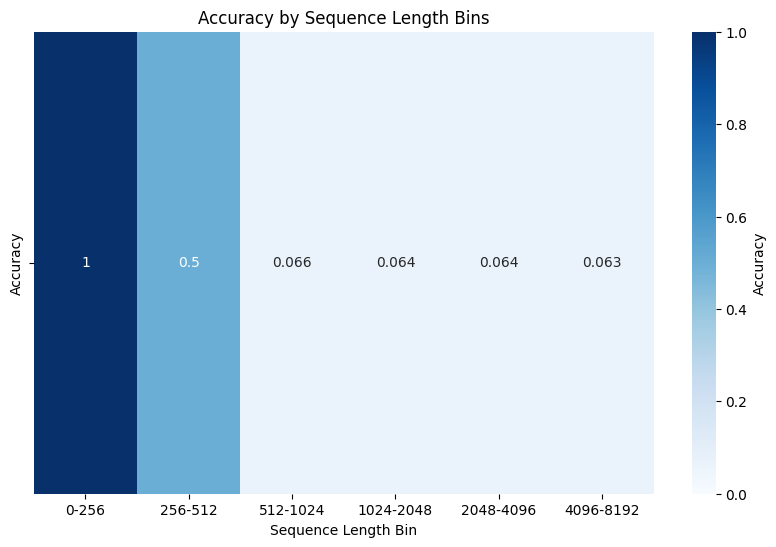

In [ ]:
accuracy_by_bins = eval_accuracy_bins(model_rope, test_loader)
plot_accuracy_heatmap_(accuracy_by_bins)

## alibi train

In [ ]:
train_loader = DataLoader(train_dataset, batch_size=8, shuffle=False, drop_last=True, num_workers=1, persistent_workers=True, pin_memory=True)


DEVICE = "cuda"
#  конфигурацию модели не менять!
D_MODEL = 128
N_HEADS = 8
N_BLOCKS = 2

model_alibi = TransformerDecoderALIBI(
    vocab_size=train_dataset.vocab_size,
    d_model=D_MODEL,
    n_heads=N_HEADS,
    n_blocks=N_BLOCKS,
    seq_len=train_dataset_size,
).to(DEVICE)


loss_fn_alibi = nn.CrossEntropyLoss()
optimizer_alibi = torch.optim.AdamW(model_alibi.parameters(), lr=1e-3, weight_decay=1e-5)

train_transformer(
    model=model_alibi,
    optimizer=optimizer_alibi,
    scheduler=None,
    loss_fn=loss_fn_alibi,
    train_loader=train_loader,
    device=DEVICE,
    num_epochs=40
)

wandb: Using wandb-core as the SDK backend.  Please refer to https://wandb.me/wandb-core for more information.


<IPython.core.display.Javascript object>

wandb: Logging into wandb.ai. (Learn how to deploy a W&B server locally: https://wandb.me/wandb-server)
wandb: You can find your API key in your browser here: https://wandb.ai/authorize
wandb: Paste an API key from your profile and hit enter, or press ctrl+c to quit:

 ··········


wandb: Appending key for api.wandb.ai to your netrc file: /root/.netrc


Epoch 1/40:   0%|          | 0/1024 [00:00<?, ?it/s]

Epoch [1/40] completed. Average Loss: 0.5879, Average Accuracy: 0.8351


Epoch 2/40:   0%|          | 0/1024 [00:00<?, ?it/s]

Epoch [2/40] completed. Average Loss: 0.0938, Average Accuracy: 0.9765


Epoch 3/40:   0%|          | 0/1024 [00:00<?, ?it/s]

Epoch [3/40] completed. Average Loss: 0.0614, Average Accuracy: 0.9841


Epoch 4/40:   0%|          | 0/1024 [00:00<?, ?it/s]

Epoch [4/40] completed. Average Loss: 0.0451, Average Accuracy: 0.9879


Epoch 5/40:   0%|          | 0/1024 [00:00<?, ?it/s]

Epoch [5/40] completed. Average Loss: 0.0362, Average Accuracy: 0.9901


Epoch 6/40:   0%|          | 0/1024 [00:00<?, ?it/s]

Epoch [6/40] completed. Average Loss: 0.0296, Average Accuracy: 0.9919


Epoch 7/40:   0%|          | 0/1024 [00:00<?, ?it/s]

Epoch [7/40] completed. Average Loss: 0.0249, Average Accuracy: 0.9932


Epoch 8/40:   0%|          | 0/1024 [00:00<?, ?it/s]

Epoch [8/40] completed. Average Loss: 0.0234, Average Accuracy: 0.9938


Epoch 9/40:   0%|          | 0/1024 [00:00<?, ?it/s]

Epoch [9/40] completed. Average Loss: 0.0206, Average Accuracy: 0.9947


Epoch 10/40:   0%|          | 0/1024 [00:00<?, ?it/s]

Epoch [10/40] completed. Average Loss: 0.0181, Average Accuracy: 0.9953


Epoch 11/40:   0%|          | 0/1024 [00:00<?, ?it/s]

Epoch [11/40] completed. Average Loss: 0.0174, Average Accuracy: 0.9956


Epoch 12/40:   0%|          | 0/1024 [00:00<?, ?it/s]

Epoch [12/40] completed. Average Loss: 0.0167, Average Accuracy: 0.9958


Epoch 13/40:   0%|          | 0/1024 [00:00<?, ?it/s]

Epoch [13/40] completed. Average Loss: 0.0151, Average Accuracy: 0.9963


Epoch 14/40:   0%|          | 0/1024 [00:00<?, ?it/s]

Epoch [14/40] completed. Average Loss: 0.0149, Average Accuracy: 0.9963


Epoch 15/40:   0%|          | 0/1024 [00:00<?, ?it/s]

Epoch [15/40] completed. Average Loss: 0.0135, Average Accuracy: 0.9967


Epoch 16/40:   0%|          | 0/1024 [00:00<?, ?it/s]

Epoch [16/40] completed. Average Loss: 0.0141, Average Accuracy: 0.9965


Epoch 17/40:   0%|          | 0/1024 [00:00<?, ?it/s]

Epoch [17/40] completed. Average Loss: 0.0124, Average Accuracy: 0.9970


Epoch 18/40:   0%|          | 0/1024 [00:00<?, ?it/s]

Epoch [18/40] completed. Average Loss: 0.0127, Average Accuracy: 0.9969


Epoch 19/40:   0%|          | 0/1024 [00:00<?, ?it/s]

Epoch [19/40] completed. Average Loss: 0.0113, Average Accuracy: 0.9973


Epoch 20/40:   0%|          | 0/1024 [00:00<?, ?it/s]

Epoch [20/40] completed. Average Loss: 0.0103, Average Accuracy: 0.9975


Epoch 21/40:   0%|          | 0/1024 [00:00<?, ?it/s]

Epoch [21/40] completed. Average Loss: 0.0113, Average Accuracy: 0.9973


Epoch 22/40:   0%|          | 0/1024 [00:00<?, ?it/s]

Epoch [22/40] completed. Average Loss: 0.0094, Average Accuracy: 0.9977


Epoch 23/40:   0%|          | 0/1024 [00:00<?, ?it/s]

Epoch [23/40] completed. Average Loss: 0.0118, Average Accuracy: 0.9973


Epoch 24/40:   0%|          | 0/1024 [00:00<?, ?it/s]

Epoch [24/40] completed. Average Loss: 0.0097, Average Accuracy: 0.9977


Epoch 25/40:   0%|          | 0/1024 [00:00<?, ?it/s]

Epoch [25/40] completed. Average Loss: 0.0101, Average Accuracy: 0.9976


Epoch 26/40:   0%|          | 0/1024 [00:00<?, ?it/s]

Epoch [26/40] completed. Average Loss: 0.0096, Average Accuracy: 0.9978


Epoch 27/40:   0%|          | 0/1024 [00:00<?, ?it/s]

Epoch [27/40] completed. Average Loss: 0.0087, Average Accuracy: 0.9979


Epoch 28/40:   0%|          | 0/1024 [00:00<?, ?it/s]

Epoch [28/40] completed. Average Loss: 0.0088, Average Accuracy: 0.9979


Epoch 29/40:   0%|          | 0/1024 [00:00<?, ?it/s]

Epoch [29/40] completed. Average Loss: 0.0098, Average Accuracy: 0.9978


Epoch 30/40:   0%|          | 0/1024 [00:00<?, ?it/s]

Epoch [30/40] completed. Average Loss: 0.0081, Average Accuracy: 0.9982


Epoch 31/40:   0%|          | 0/1024 [00:00<?, ?it/s]

Epoch [31/40] completed. Average Loss: 0.0072, Average Accuracy: 0.9983


Epoch 32/40:   0%|          | 0/1024 [00:00<?, ?it/s]

Epoch [32/40] completed. Average Loss: 0.0085, Average Accuracy: 0.9981


Epoch 33/40:   0%|          | 0/1024 [00:00<?, ?it/s]

Epoch [33/40] completed. Average Loss: 0.0089, Average Accuracy: 0.9981


Epoch 34/40:   0%|          | 0/1024 [00:00<?, ?it/s]

Epoch [34/40] completed. Average Loss: 0.0062, Average Accuracy: 0.9985


Epoch 35/40:   0%|          | 0/1024 [00:00<?, ?it/s]

Epoch [35/40] completed. Average Loss: 0.0092, Average Accuracy: 0.9979


Epoch 36/40:   0%|          | 0/1024 [00:00<?, ?it/s]

Epoch [36/40] completed. Average Loss: 0.0063, Average Accuracy: 0.9985


Epoch 37/40:   0%|          | 0/1024 [00:00<?, ?it/s]

Epoch [37/40] completed. Average Loss: 0.0073, Average Accuracy: 0.9984


Epoch 38/40:   0%|          | 0/1024 [00:00<?, ?it/s]

Epoch [38/40] completed. Average Loss: 0.0072, Average Accuracy: 0.9983


Epoch 39/40:   0%|          | 0/1024 [00:00<?, ?it/s]

Epoch [39/40] completed. Average Loss: 0.0079, Average Accuracy: 0.9983


Epoch 40/40:   0%|          | 0/1024 [00:00<?, ?it/s]

Epoch [40/40] completed. Average Loss: 0.0061, Average Accuracy: 0.9986


epoch_accuracy,▁▇▇█████████████████████████████████████
epoch_loss,█▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
epoch_accuracy,0.99855
epoch_loss,0.00609


In [ ]:
torch.cuda.empty_cache()

  0%|          | 0/256 [00:00<?, ?it/s]

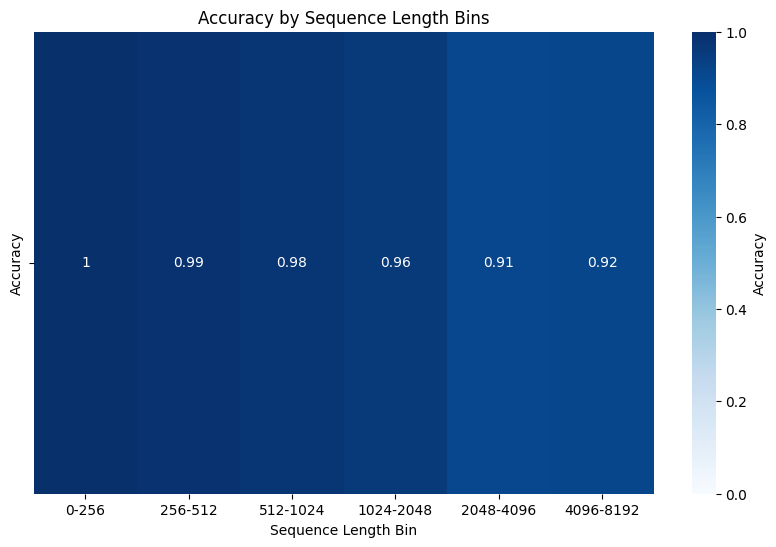

In [ ]:
accuracy_by_bins = eval_accuracy_bins(model_alibi, test_loader)
plot_accuracy_heatmap_(accuracy_by_bins)

УХТЫ, алиби показало себя очень круто

#Выводы

по итогу получаем gpt -> gpt + pos_enconder -> gpt + rope -> gpt + alibi, в целом достаточно интнерсно, думаю что все таки решает то, что в алиби по факту допом идет обучаемое смещение (bias) которое и дает неплохой буст на длинных предожениях

## 6. Mamba

In [ ]:
! pip install mamba-ssm[causal-conv1d] -q

In [ ]:
D_MAMBA = D_MODEL // 2
mamba_block = Mamba(
    # This module uses roughly 3 * expand * d_model^2 parameters
    d_model=dim, # Model dimension d_model
    d_state=16,  # SSM state expansion factor
    d_conv=4,    # Local convolution width
    expand=2,    # Block expansion factor
).to(DEVICE)